In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load the data
data = pd.read_csv('/content/AEP_hourly new.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index('Datetime')

<ipython-input-14-195ac6e3a11e>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Datetime'] = pd.to_datetime(data['Datetime'])


In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['AEP_MW']])

In [ ]:
# Split the data into training and test sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]


In [ ]:
# Reshape the data for LSTM input
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 1
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [ ]:
# Reshape the input for LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Build the RNN model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
# Train the model
history= model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1516/1516 [==============================] - 4s 3ms/step - loss: 0.0016
Epoch 2/5
1516/1516 [==============================] - 5s 3ms/step - loss: 0.0016
Epoch 3/5
1516/1516 [==============================] - 4s 3ms/step - loss: 0.0016
Epoch 4/5
1516/1516 [==============================] - 4s 3ms/step - loss: 0.0016
Epoch 5/5
1516/1516 [==============================] - 5s 3ms/step - loss: 0.0016


In [50]:
# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

758/758 [==============================] - 1s 2ms/step


In [51]:
# Invert the normalization
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Calculate the metrics
train_mse = mean_squared_error(y_train_inv, train_predict)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_inv, train_predict)
train_r2 = r2_score(y_train_inv, train_predict)

test_mse = mean_squared_error(y_test_inv, test_predict)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_inv, test_predict)
test_r2 = r2_score(y_test_inv, test_predict)

In [53]:
print('Train MSE: {:.2f}'.format(train_mse))
print('Train RMSE: {:.2f}'.format(train_rmse))
print('Train MAE: {:.2f}'.format(train_mae))
print('Test MSE: {:.2f}'.format(test_mse))
print('Test RMSE: {:.2f}'.format(test_rmse))
print('Test MAE: {:.2f}'.format(test_mae))
print('Train R2 score: {:.2f}'.format(train_r2))
print('Test R2 score: {:.2f}'.format(test_r2))


Train MSE: 408914.60
Train RMSE: 639.46
Train MAE: 458.83
Test MSE: 366932.32
Test RMSE: 605.75
Test MAE: 436.32
Train R2 score: 0.94
Test R2 score: 0.94


In [54]:
# Get user input
user_input = input("Enter the next AEP_MW value: ")
user_input_array = np.array([float(user_input)])
user_input_scaled = scaler.transform(np.expand_dims(user_input_array, axis=1))
user_input_reshaped = np.reshape(user_input_scaled, (1, 1, 1))

# Make a prediction
prediction = model.predict(user_input_reshaped)
prediction_inverse = scaler.inverse_transform(prediction)

print("Predicted AEP_MW:", prediction_inverse[0][0])

Enter the next AEP_MW value: 14500
1/1 [==============================] - 0s 22ms/step
Predicted AEP_MW: 14506.173


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


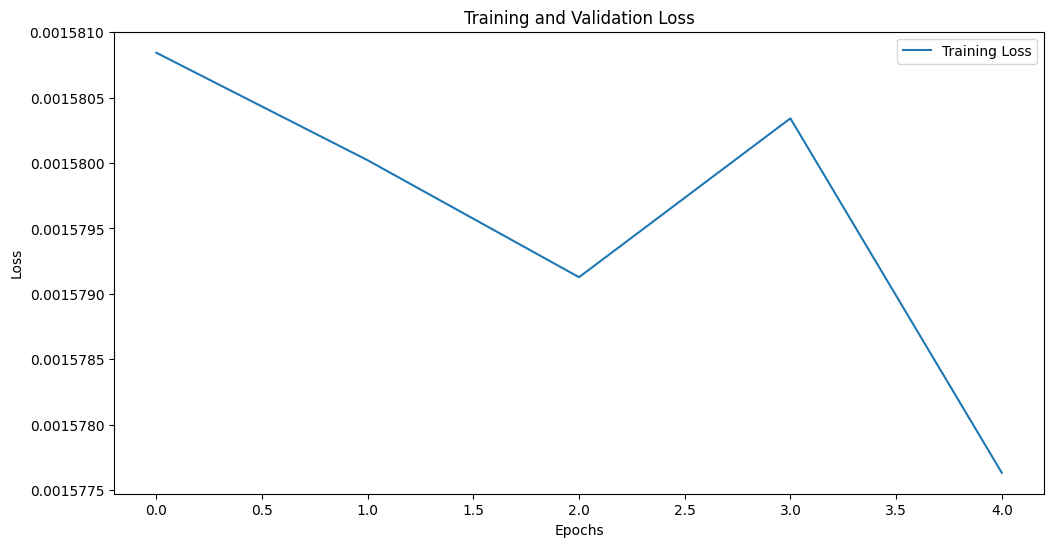

In [58]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()